# MNIST

# ZO-SGD

In [175]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
import seaborn as sns
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

criterion = nn.CrossEntropyLoss()  
model = SimpleNet()
zo_sgd_train_loss = []
zo_sgd_train_acc = []
zo_sgd_test_loss = []
zo_sgd_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01):  
    model.train()  
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        lr = lr / epoch
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            loss.backward()
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    param.data -= lr * grad_estimates[name]  
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_sgd_train_acc.append(train_accuracy)
        zo_sgd_test_acc.append(test_accuracy)
        zo_sgd_train_loss.append(train_loss)
        zo_sgd_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)   
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301988
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.292105
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.314113
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.285865
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.285676
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.274646
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.260589
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.267931
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.266407
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.257386
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.262375
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.275832
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.198195
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.164056
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.146588
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.199651
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.200770
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.151838
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.173018
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.108977
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.263292
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.202157
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.252573
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.087428
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.218250
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.995908
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.360917
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.244042
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.082697
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.096353
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.223469
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.174830
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.180948
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.240706
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.294649
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.087492
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.963042
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.215991
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.157318
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.973399


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.941006
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.909131
Train Epoch: 4 [24320/60000 (41%)]	Loss: 1.182114
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.944887
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.961727
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.934740
Train Epoch: 4 [26880/60000 (45%)]	Loss: 1.095737
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.104083
Train Epoch: 4 [28160/60000 (47%)]	Loss: 1.016768
Train Epoch: 4 [28800/60000 (48%)]	Loss: 1.037151
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.987096
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.819978
Train Epoch: 4 [30720/60000 (51%)]	Loss: 1.027128
Train Epoch: 4 [31360/60000 (52%)]	Loss: 1.095234
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.909298
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.937496
Train Epoch: 4 [33280/60000 (55%)]	Loss: 1.042723
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.926703
Train Epoch: 4 [34560/60000 (58%)]	Loss: 1.106755
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.010029


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.925888
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.999632
Train Epoch: 6 [4480/60000 (7%)]	Loss: 1.126568
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.957655
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.802388
Train Epoch: 6 [6400/60000 (11%)]	Loss: 1.100675
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.935214
Train Epoch: 6 [7680/60000 (13%)]	Loss: 1.033279
Train Epoch: 6 [8320/60000 (14%)]	Loss: 1.086588
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.984374
Train Epoch: 6 [9600/60000 (16%)]	Loss: 1.012746
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.946843
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.910286
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.946134
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.991648
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.943327
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.796666
Train Epoch: 6 [14080/60000 (23%)]	Loss: 1.056176
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.857255
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.907189
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.931663
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.967226
Train Epoch: 7 [47360/60000 (79%)]	Loss: 1.099805
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.906340
Train Epoch: 7 [48640/60000 (81%)]	Loss: 1.026768
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.999101
Train Epoch: 7 [49920/60000 (83%)]	Loss: 1.028690
Train Epoch: 7 [50560/60000 (84%)]	Loss: 1.065888
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.020283
Train Epoch: 7 [51840/60000 (86%)]	Loss: 1.057584
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.972190
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.893759
Train Epoch: 7 [53760/60000 (90%)]	Loss: 1.017139
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.883863
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.830287
Train Epoch: 7 [55680/60000 (93%)]	Loss: 1.032614
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.918081
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.934037
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.953727
Train Epoch: 7 [58240/60000 (97%)]	Loss: 1.040964


Train Epoch: 9 [26240/60000 (44%)]	Loss: 1.002088
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.942034
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.956664
Train Epoch: 9 [28160/60000 (47%)]	Loss: 1.123358
Train Epoch: 9 [28800/60000 (48%)]	Loss: 1.072879
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.976068
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.916682
Train Epoch: 9 [30720/60000 (51%)]	Loss: 1.056340
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.883616
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.968645
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.912726
Train Epoch: 9 [33280/60000 (55%)]	Loss: 1.105782
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.995399
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.954593
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.964314
Train Epoch: 9 [35840/60000 (60%)]	Loss: 1.046289
Train Epoch: 9 [36480/60000 (61%)]	Loss: 1.069916
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.926354
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.911890
Train Epoch: 9 [38400/60000 (64%)]	Loss: 1.003608


# ZO-AdaNorm

In [176]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

model = SimpleNet()
zo_ada_train_loss = []
zo_ada_train_acc = []
zo_ada_test_loss = []
zo_ada_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01, b=1):  
    model.train()  
    cnt = 0
    g = {}
    for name, param in model.named_parameters():
        g[name] = 0
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    param.data -= 1.6 / sqrt(b + g[name]) * grad_estimates[name]  
                    g[name] += torch.pow(torch.norm(grad_estimates[name]),2)
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_ada_train_acc.append(train_accuracy)
        zo_ada_test_acc.append(test_accuracy)
        zo_ada_train_loss.append(train_loss)
        zo_ada_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
criterion = nn.CrossEntropyLoss()  
  
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01, b = 100)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302383
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.250741
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.230460
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.226797
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.245383
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.127447
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.175675
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.204237
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.173724
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.144990
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.180438
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.132026
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.097756
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.056824
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.019659
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.157911
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.099501
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.023301
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.035764
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.980017
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.480002
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.492049
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.459287
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.339381
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.476659
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.296529
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.518869
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.504607
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.363604
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.304673
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.415881
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.445297
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.494262
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.452208
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.491429
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.323785
Train Epoch: 2 [53120/60000 (88%)]	Loss: 1.219215
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.467372
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.403176
Train Epoch: 2 [55040/60000 (92%)]	Loss: 1.283221


Train Epoch: 4 [23040/60000 (38%)]	Loss: 1.107893
Train Epoch: 4 [23680/60000 (39%)]	Loss: 1.112566
Train Epoch: 4 [24320/60000 (41%)]	Loss: 1.300826
Train Epoch: 4 [24960/60000 (42%)]	Loss: 1.112209
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.167943
Train Epoch: 4 [26240/60000 (44%)]	Loss: 1.186586
Train Epoch: 4 [26880/60000 (45%)]	Loss: 1.229713
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.335043
Train Epoch: 4 [28160/60000 (47%)]	Loss: 1.194842
Train Epoch: 4 [28800/60000 (48%)]	Loss: 1.143015
Train Epoch: 4 [29440/60000 (49%)]	Loss: 1.094024
Train Epoch: 4 [30080/60000 (50%)]	Loss: 1.048009
Train Epoch: 4 [30720/60000 (51%)]	Loss: 1.182488
Train Epoch: 4 [31360/60000 (52%)]	Loss: 1.267478
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.107247
Train Epoch: 4 [32640/60000 (54%)]	Loss: 1.146166
Train Epoch: 4 [33280/60000 (55%)]	Loss: 1.241785
Train Epoch: 4 [33920/60000 (57%)]	Loss: 1.160880
Train Epoch: 4 [34560/60000 (58%)]	Loss: 1.156755
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.109628


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.969192
Train Epoch: 6 [3840/60000 (6%)]	Loss: 1.100153
Train Epoch: 6 [4480/60000 (7%)]	Loss: 1.112007
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.938437
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.887092
Train Epoch: 6 [6400/60000 (11%)]	Loss: 1.125222
Train Epoch: 6 [7040/60000 (12%)]	Loss: 1.009584
Train Epoch: 6 [7680/60000 (13%)]	Loss: 1.016433
Train Epoch: 6 [8320/60000 (14%)]	Loss: 1.126483
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.984855
Train Epoch: 6 [9600/60000 (16%)]	Loss: 1.000061
Train Epoch: 6 [10240/60000 (17%)]	Loss: 1.028039
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.948931
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.980144
Train Epoch: 6 [12160/60000 (20%)]	Loss: 1.057184
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.971432
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.835621
Train Epoch: 6 [14080/60000 (23%)]	Loss: 1.101052
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.812882
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.981268
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.860240
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.857573
Train Epoch: 7 [47360/60000 (79%)]	Loss: 1.061114
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.912098
Train Epoch: 7 [48640/60000 (81%)]	Loss: 1.001478
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.914318
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.901780
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.902968
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.929019
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.906596
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.931112
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.856767
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.934905
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.922426
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.772582
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.929658
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.919363
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.923826
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.837647
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.970110


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.935340
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.824231
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.800436
Train Epoch: 9 [28160/60000 (47%)]	Loss: 1.021597
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.963097
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.852574
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.876330
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.962406
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.797882
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.891446
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.761451
Train Epoch: 9 [33280/60000 (55%)]	Loss: 1.000635
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.960093
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.970624
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.881141
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.919888
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.931554
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.862546
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.798247
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.801361


# ZO-AdaHB

In [177]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

model = SimpleNet()
zo_adahb_train_loss = []
zo_adahb_train_acc = []
zo_adahb_test_loss = []
zo_adahb_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01, b=1, theta=0.05):  
    model.train()  
    cnt = 0
    g = {}
    data = {}
    for name, param in model.named_parameters():
        g[name] = 0
        data[name] = None
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    if data[name] == None:
                        tmp = param.data
                        param.data = param.data - 1.6 / sqrt(b + g[name]) * grad_estimates[name]
                        data[name] = param.data - tmp
                    else:
                        tmp = param.data
                        param.data = param.data - 1.6 / sqrt(b + g[name]) * grad_estimates[name] + theta * data[name] 
                        data[name] = param.data - tmp
                    g[name] += torch.pow(torch.norm(grad_estimates[name]),2)
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_adahb_train_acc.append(train_accuracy)
        zo_adahb_test_acc.append(test_accuracy)
        zo_adahb_train_loss.append(train_loss)
        zo_adahb_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
criterion = nn.CrossEntropyLoss()  
  
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01, b = 100, theta=0.3)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302383
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.274856
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.204886
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.146686
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.108871
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.957746
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.030656
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.122602
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.083334
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.986274
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.072484
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.990843
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.980124
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.859756
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.785195
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.063470
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.968285
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.871927
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.831625
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.816123
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.177760
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.169072
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.182388
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.037210
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.235084
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.058940
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.292563
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.266803
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.054202
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.006105
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.228952
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.279890
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.304819
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.152570
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.213584
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.970085
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.877643
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.236410
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.096739
Train Epoch: 2 [55040/60000 (92%)]	Loss: 1.000106


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.856961
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.912715
Train Epoch: 4 [24320/60000 (41%)]	Loss: 1.106815
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.858914
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.922539
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.951173
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.945228
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.104376
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.930231
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.932609
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.802076
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.821701
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.967951
Train Epoch: 4 [31360/60000 (52%)]	Loss: 1.043613
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.937881
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.915148
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.980467
Train Epoch: 4 [33920/60000 (57%)]	Loss: 1.015961
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.977073
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.885494


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.795657
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.892216
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.874960
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.714082
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.593207
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.988954
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.843407
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.857512
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.922465
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.838543
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.802873
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.855501
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.702894
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.744998
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.922695
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.844635
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.607001
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.863702
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.626180
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.823051
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.689025
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.702445
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.919127
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.752375
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.856986
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.719364
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.720934
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.682967
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.795877
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.747467
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.758395
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.705808
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.743858
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.673948
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.588488
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.819268
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.744856
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.731126
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.690932
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.829858


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.811064
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.616800
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.684453
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.945480
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.869406
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.714055
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.761370
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.861449
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.621574
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.807894
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.695506
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.894390
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.887064
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.875293
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.723142
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.759731
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.773752
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.749786
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.729179
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.641821


# ZO-AdaNesterov

In [178]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

model = SimpleNet()
zo_adanesterov_train_loss = []
zo_adanesterov_train_acc = []
zo_adanesterov_test_loss = []
zo_adanesterov_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01, b=1, theta=0.05):  
    model.train()  
    cnt = 0
    g = {}
    data = {}
    for name, param in model.named_parameters():
        g[name] = 0
        data[name] = None
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                if data[name] == None:
                    data[name] = 0
                with torch.no_grad():  
                    param.data = param_origin + theta * data[name]
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin + theta * data[name]
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    tmp = param.data
                    param.data = param.data + theta * data[name] - 1.6 / sqrt(b + g[name]) * grad_estimates[name] 
                    g[name] += torch.pow(torch.norm(grad_estimates[name]),2)
                    data[name] = param.data - tmp
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_adanesterov_train_acc.append(train_accuracy)
        zo_adanesterov_test_acc.append(test_accuracy)
        zo_adanesterov_train_loss.append(train_loss)
        zo_adanesterov_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
criterion = nn.CrossEntropyLoss()  
  
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01, b = 100, theta=0.3)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302383
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.242627
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.224278
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.131312
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.150751
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.973310
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.031710
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.176054
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.071342
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.986269
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.026212
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.995275
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.954312
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.827837
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.749871
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.008963
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.941696
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.851893
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.821158
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.782684
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.180000
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.147250
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.202045
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.027632
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.228559
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.043920
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.302142
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.244584
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.067264
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.021746
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.198551
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.240727
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.297796
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.141598
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.199822
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.941843
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.867627
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.240385
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.066647
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.997123


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.849618
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.879449
Train Epoch: 4 [24320/60000 (41%)]	Loss: 1.058741
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.840195
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.907856
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.903730
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.927664
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.054244
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.940470
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.889655
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.784128
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.789407
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.924296
Train Epoch: 4 [31360/60000 (52%)]	Loss: 1.000545
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.898707
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.889080
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.910423
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.982517
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.963479
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.862724


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.797006
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.890595
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.854610
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.732538
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.584595
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.964443
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.810340
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.817876
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.932721
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.823074
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.773664
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.858653
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.724844
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.726577
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.891287
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.859504
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.594495
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.856782
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.629334
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.801011
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.713320
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.700025
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.888195
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.725192
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.863786
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.725614
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.692589
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.706314
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.804725
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.760418
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.760852
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.700287
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.738297
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.692083
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.564174
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.803045
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.676569
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.701258
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.713845
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.821240


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.794788
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.620389
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.627846
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.926461
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.849755
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.696100
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.678590
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.784207
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.641072
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.817581
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.644343
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.868919
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.875884
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.820593
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.703391
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.763242
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.758210
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.701043
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.659243
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.636536


# ZO-AdaMM

In [179]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
import numpy as np
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 
criterion = nn.CrossEntropyLoss()  
model = SimpleNet()
zo_adamm_train_loss = []
zo_adamm_train_acc = []
zo_adamm_test_loss = []
zo_adamm_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01):  
    model.train()  
    beta_1 = 0.9
    beta_2 = 0.3
    v_init = 1e-5
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        lr = lr / np.sqrt(epoch)
        m, v, v_hat = {}, {}, {}

        for name, param in model.named_parameters():
            m[name] = torch.zeros(param.shape)
            v[name] = torch.ones(param.shape) * v_init
            v_hat[name] = torch.ones(param.shape) * v_init
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    g_k = grad_estimates[name]
                    m[name] = m[name].to("cuda")
                    v[name] = v[name].to("cuda")
                    v_hat[name] = v_hat[name].to("cuda")
                    v[name] = beta_2 * v[name] + (1-beta_2) * torch.square(g_k)
                    m[name] = beta_1 * m[name] + (1-beta_1) * g_k
                    v_hat[name] = torch.maximum(v_hat[name],v[name])
                    param.data -= lr * m[name] / torch.sqrt(v_hat[name]) 
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_adamm_train_acc.append(train_accuracy)
        zo_adamm_test_acc.append(test_accuracy)
        zo_adamm_train_loss.append(train_loss)
        zo_adamm_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)   
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299837
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.272548
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.292197
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.307708
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.280878
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.256166
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.203088
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.198116
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.193186
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.118979
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.200627
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.148323
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.090047
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.973659
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.999981
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.110137
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.083873
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.998345
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.967647
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.914485
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.148162
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.826729
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.093848
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.712414
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.047561
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.741398
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.323369
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.971184
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.897228
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.751355
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.879415
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.930023
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.989337
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.065579
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.163598
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.761208
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.677479
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.967260
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.048451
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.867103


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.788231
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.711402
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.977127
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.660616
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.698001
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.695998
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.815872
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.004358
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.664158
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.683910
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.609892
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.667731
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.840815
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.914708
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.685348
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.588488
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.853984
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.641948
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.828866
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.747479


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.534072
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.755816
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.751524
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.593884
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.496979
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.881067
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.638917
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.833028
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.999764
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.772398
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.737671
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.644638
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.625702
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.681992
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.640290
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.689831
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.576306
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.765819
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.555768
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.673389
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.633346
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.625356
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.830714
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.698528
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.919195
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.736207
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.668932
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.703715
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.885178
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.826844
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.648354
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.637592
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.841422
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.673794
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.593577
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.802607
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.663659
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.708403
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.690411
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.878482


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.666721
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.622443
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.678593
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.831707
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.754233
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.644760
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.560854
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.832876
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.603342
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.756816
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.748977
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.988941
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.720257
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.564206
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.679274
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.719548
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.755605
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.720604
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.605811
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.671240


In [180]:
zo_ada_train_acc = [i / 100 for i in zo_ada_train_acc]
zo_sgd_train_acc = [i / 100 for i in zo_sgd_train_acc]
zo_adahb_train_acc = [i / 100 for i in zo_adahb_train_acc]
zo_adanesterov_train_acc = [i / 100 for i in zo_adanesterov_train_acc]
zo_adamm_train_acc = [i / 100 for i in zo_adamm_train_acc]
zo_ada_test_acc = [i / 100 for i in zo_ada_test_acc]
zo_sgd_test_acc = [i / 100 for i in zo_sgd_test_acc]
zo_adahb_test_acc = [i / 100 for i in zo_adahb_test_acc]
zo_adanesterov_test_acc = [i / 100 for i in zo_adanesterov_test_acc]
zo_adamm_test_acc = [i / 100 for i in zo_adamm_test_acc]

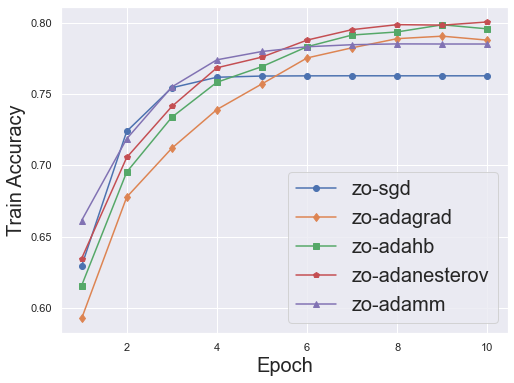

In [181]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

x = range(1,11)

plt.figure(figsize=(8,6))

plt.plot(x,zo_sgd_train_acc, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_train_acc, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_train_acc, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_train_acc, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_train_acc, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Train Accuracy",fontsize=20)
plt.grid(c='w')
plt.legend(loc='lower right',fontsize=20)

plt.savefig('mnist_train_acc.png', dpi=300)
plt.show()

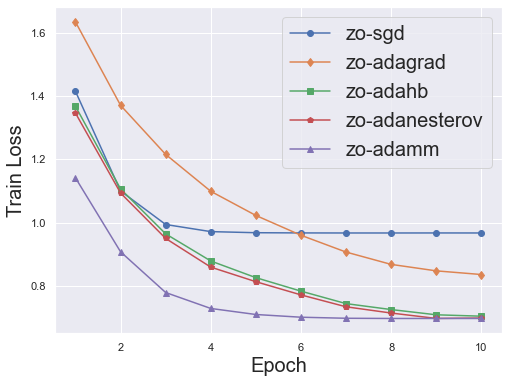

In [182]:
plt.figure(figsize=(8,6))
# plt.title("Loss")
plt.plot(x,zo_sgd_train_loss, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_train_loss, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_train_loss, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_train_loss, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_train_loss, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Train Loss",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('mnist_train_loss.png', dpi=300)
plt.show()

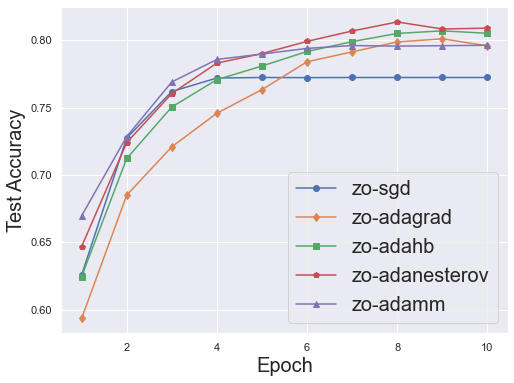

In [183]:
plt.figure(figsize=(8,6))
# plt.title("Test Accuracy")
plt.plot(x,zo_sgd_test_acc, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_test_acc, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_test_acc, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_test_acc, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_test_acc, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Test Accuracy",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('mnist_test_acc.png', dpi=300)
plt.show()

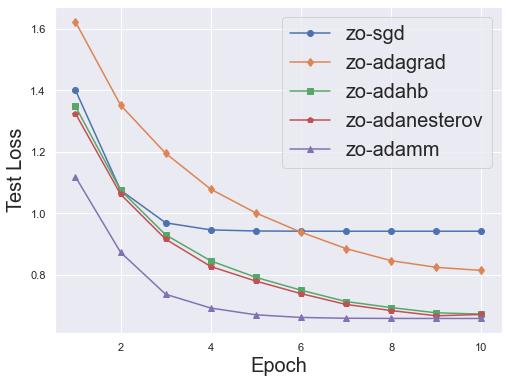

In [184]:
plt.figure(figsize=(8,6))
# plt.title("Test Loss")
plt.plot(x,zo_sgd_test_loss, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_test_loss, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_test_loss, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_test_loss, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_test_loss, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Test Loss",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('mnist_test_loss.png', dpi=300)
plt.show()

# Fashion Mnist

# ZO-SGD

In [185]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 
criterion = nn.CrossEntropyLoss()  
model = SimpleNet()
zo_sgd_train_loss = []
zo_sgd_train_acc = []
zo_sgd_test_loss = []
zo_sgd_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01):  
    model.train()  
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        lr = lr / epoch
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            loss.backward()
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    param.data -= lr * grad_estimates[name]  
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_sgd_train_acc.append(train_accuracy)
        zo_sgd_test_acc.append(test_accuracy)
        zo_sgd_train_loss.append(train_loss)
        zo_sgd_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)   
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327820
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.329815
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.259326
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.224801
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.242451
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.180289
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.183827
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.163377
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.239692
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.127470
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.133443
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.142851
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.112709
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.169300
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.128717
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.114864
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.136808
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.090752
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.069069
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.977841
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.073600
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.950129
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.055534
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.976012
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.092480
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.010898
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.917114
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.918699
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.949625
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.001118
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.981234
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.998893
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.735420
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.976850
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.019882
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.082005
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.909136
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.944774
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.025241
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.880626


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.879764
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.886377
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.822318
Train Epoch: 4 [24960/60000 (42%)]	Loss: 1.001511
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.811467
Train Epoch: 4 [26240/60000 (44%)]	Loss: 1.035086
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.897860
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.034908
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.747258
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.917621
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.882050
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.922161
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.884538
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.916890
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.901320
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.894717
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.967797
Train Epoch: 4 [33920/60000 (57%)]	Loss: 1.020826
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.906230
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.922379


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.774211
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.796539
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.647749
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.822869
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.974156
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.814641
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.894595
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.895920
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.975097
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.783112
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.944674
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.879888
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.790243
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.970654
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.829201
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.785455
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.858576
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.943816
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.848027
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.912832
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.865633
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.814007
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.894032
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.940078
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.809859
Train Epoch: 7 [49280/60000 (82%)]	Loss: 1.017755
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.897465
Train Epoch: 7 [50560/60000 (84%)]	Loss: 1.047527
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.951202
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.929054
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.982407
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.878839
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.910396
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.905182
Train Epoch: 7 [55040/60000 (92%)]	Loss: 1.119395
Train Epoch: 7 [55680/60000 (93%)]	Loss: 1.014788
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.850625
Train Epoch: 7 [56960/60000 (95%)]	Loss: 1.001999
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.827592
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.879816


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.846001
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.857828
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.854384
Train Epoch: 9 [28160/60000 (47%)]	Loss: 1.042874
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.983596
Train Epoch: 9 [29440/60000 (49%)]	Loss: 1.004336
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.912072
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.870172
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.920342
Train Epoch: 9 [32000/60000 (53%)]	Loss: 1.066545
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.771086
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.857556
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.810242
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.871891
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.839749
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.930884
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.997802
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.989378
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.881778
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.793025


# ZO-AdaNorm

In [186]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

model = SimpleNet()
zo_ada_train_loss = []
zo_ada_train_acc = []
zo_ada_test_loss = []
zo_ada_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01, b=1):  
    model.train()  
    cnt = 0
    g = {}
    for name, param in model.named_parameters():
        g[name] = 0
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    param.data -= 1.7 / sqrt(b + g[name]) * grad_estimates[name]  
                    g[name] += torch.pow(torch.norm(grad_estimates[name]),2)
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_ada_train_acc.append(train_accuracy)
        zo_ada_test_acc.append(test_accuracy)
        zo_ada_train_loss.append(train_loss)
        zo_ada_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
criterion = nn.CrossEntropyLoss()  
  
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01, b = 100)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352245
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.261942
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.118441
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.090920
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.008868
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.870420
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.824826
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.889004
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.822456
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.790079
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.914623
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.834547
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.668789
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.855602
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.791496
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.780080
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.754314
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.739771
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.678743
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.563576
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.014493
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.905971
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.167561
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.071363
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.087205
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.064073
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.936254
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.848881
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.878396
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.032322
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.045074
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.001488
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.797427
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.178612
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.043980
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.161499
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.974815
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.024746
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.984593
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.912486


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.837992
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.806347
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.812917
Train Epoch: 4 [24960/60000 (42%)]	Loss: 1.012448
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.712961
Train Epoch: 4 [26240/60000 (44%)]	Loss: 1.000849
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.891571
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.039632
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.683830
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.903208
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.903636
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.988690
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.950875
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.917385
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.939912
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.885527
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.911456
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.921511
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.879385
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.949522


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.701768
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.710221
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.596529
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.771894
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.847432
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.740248
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.750265
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.751845
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.874902
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.749406
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.764103
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.794726
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.728587
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.952358
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.739885
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.738953
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.792032
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.865052
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.750356
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.846721
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.844097
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.772904
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.749721
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.811165
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.672372
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.863277
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.789881
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.854946
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.850971
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.900238
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.977096
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.887949
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.749526
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.711530
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.997147
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.968148
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.779346
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.882078
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.816639
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.764324


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.765735
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.724129
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.734700
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.895810
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.856600
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.808632
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.790682
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.749493
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.704371
Train Epoch: 9 [32000/60000 (53%)]	Loss: 1.078503
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.650380
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.638023
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.623320
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.748756
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.779446
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.746664
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.821144
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.844551
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.689669
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.640444


# ZO-AdaHB

In [187]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

# model = CNN()
model = SimpleNet()
zo_adahb_train_loss = []
zo_adahb_train_acc = []
zo_adahb_test_loss = []
zo_adahb_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01, b=1, theta=0.05):  
    model.train()  
    cnt = 0
    g = {}
    data = {}
    for name, param in model.named_parameters():
        g[name] = 0
        data[name] = None
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
#             loss.backward()
#             print(targets)
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    if data[name] == None:
                        tmp = param.data
                        param.data = param.data - 1.7 / sqrt(b + g[name]) * grad_estimates[name]
                        data[name] = param.data - tmp
                    else:
                        tmp = param.data
                        param.data = param.data - 1.7 / sqrt(b + g[name]) * grad_estimates[name] + theta * data[name] 
                        data[name] = param.data - tmp
                    g[name] += torch.pow(torch.norm(grad_estimates[name]),2)
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_adahb_train_acc.append(train_accuracy)
        zo_adahb_test_acc.append(test_accuracy)
        zo_adahb_train_loss.append(train_loss)
        zo_adahb_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
criterion = nn.CrossEntropyLoss()  
  
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01, b = 100, theta=0.15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352245
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299196
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.176795
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.200934
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.075637
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.889188
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.820708
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.932318
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.793459
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.819479
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.942066
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.829978
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.692261
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.873898
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.811992
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.741764
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.764609
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.759734
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.658584
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.513025
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.991056
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.844468
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.106171
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.045512
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.065263
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.017025
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.881023
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.784387
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.842147
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.996367
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.005487
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.967821
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.743055
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.115864
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.018306
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.158140
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.918741
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.016512
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.944973
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.855220


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.797321
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.768680
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.784790
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.990482
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.692965
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.974381
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.872788
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.996509
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.642247
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.888457
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.891609
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.992686
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.935230
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.916457
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.941645
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.864423
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.877370
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.890169
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.861128
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.928177


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.674306
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.675901
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.571336
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.741325
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.833047
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.736868
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.721133
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.726325
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.864462
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.752509
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.736504
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.732393
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.714904
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.941149
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.701046
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.717797
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.752444
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.843107
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.752914
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.824656
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.835522
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.757753
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.697768
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.777023
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.648375
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.831436
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.765815
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.842459
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.812775
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.904143
Train Epoch: 7 [52480/60000 (87%)]	Loss: 1.011391
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.925282
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.729187
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.670566
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.993663
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.948268
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.762837
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.881981
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.820078
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.755790


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.802984
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.701212
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.719341
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.891729
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.817723
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.824118
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.793327
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.736038
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.712807
Train Epoch: 9 [32000/60000 (53%)]	Loss: 1.101049
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.632057
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.590077
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.609356
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.739137
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.798465
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.756254
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.796331
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.864282
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.704003
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.645384


# ZO-AdaNesterov

In [188]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 128 * 7 * 7)
        x = self.fc1(x)
#         x = self.dp(x)
        x = F.relu(x)
#         x = self.dp(x)
        x = self.fc2(x)  
#         x = self.dp(x)
        return F.softmax(x)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 

# model = CNN()
model = SimpleNet()
zo_adanesterov_train_loss = []
zo_adanesterov_train_acc = []
zo_adanesterov_test_loss = []
zo_adanesterov_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01, b=1, theta=0.05):  
    model.train()  
    cnt = 0
    g = {}
    data = {}
    for name, param in model.named_parameters():
        g[name] = 0
        data[name] = None
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
#             loss.backward()
#             print(targets)
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                if data[name] == None:
                    data[name] = 0
                with torch.no_grad():  
                    param.data = param_origin + theta * data[name]
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin + theta * data[name]
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    tmp = param.data
                    param.data = param.data + theta * data[name] - 1.7 / sqrt(b + g[name]) * grad_estimates[name] 
                    g[name] += torch.pow(torch.norm(grad_estimates[name]),2)
                    data[name] = param.data - tmp
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_adanesterov_train_acc.append(train_accuracy)
        zo_adanesterov_test_acc.append(test_accuracy)
        zo_adanesterov_train_loss.append(train_loss)
        zo_adanesterov_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
criterion = nn.CrossEntropyLoss()  
  
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01, b = 100, theta=0.2)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352245
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.332647
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.235191
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.240717
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.106897
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.884632
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.801749
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.928225
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.780722
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.807393
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.959920
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.823037
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.722411
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.882355
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.816786
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.713954
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.769255
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.764128
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.654704
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.490953
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.011118
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.832547
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.085033
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.038122
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.059467
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.007882
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.853653
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.769573
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.825280
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.985963
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.000370
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.951950
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.740535
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.107731
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.012949
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.160431
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.906758
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.021485
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.927205
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.831162


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.778823
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.750920
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.779039
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.990920
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.700526
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.951353
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.882200
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.988565
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.625309
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.882470
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.899638
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.999786
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.933601
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.934876
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.945620
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.851917
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.872369
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.876918
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.857052
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.932033


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.665482
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.673702
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.563554
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.735566
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.825470
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.738547
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.727430
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.728740
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.865678
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.769149
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.732768
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.698562
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.717062
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.931872
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.693126
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.716369
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.752610
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.836454
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.767088
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.825463
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.828206
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.755135
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.690820
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.768666
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.641036
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.803734
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.733067
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.818448
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.809039
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.897804
Train Epoch: 7 [52480/60000 (87%)]	Loss: 1.010219
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.946787
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.739102
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.664877
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.998281
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.943834
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.754648
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.886238
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.831305
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.767765


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.808235
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.665106
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.723631
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.880143
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.786828
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.813925
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.773458
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.743514
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.704918
Train Epoch: 9 [32000/60000 (53%)]	Loss: 1.126877
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.650635
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.595935
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.626692
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.752885
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.808305
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.774662
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.804873
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.872703
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.686391
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.599209


# ZO-AdaMM

In [189]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from tqdm import tqdm
import torch.nn.functional as F
from math import *
import numpy as np
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
class SimpleNet(nn.Module):  
    def __init__(self):  
        super(SimpleNet, self).__init__()  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
  
    def forward(self, x):  
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)  
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 128 * 7 * 7)
        x = self.fc1(x)
#         x = self.dp(x)
        x = F.relu(x)
#         x = self.dp(x)
        x = self.fc2(x)  
#         x = self.dp(x)
#         print(F.softmax(x, dim=0))
        return F.log_softmax(x, dim=1)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) 
criterion = nn.CrossEntropyLoss()  
# model = CNN()
model = SimpleNet()
zo_adamm_train_loss = []
zo_adamm_train_acc = []
zo_adamm_test_loss = []
zo_adamm_test_acc = []
def test(model, device, test_loader):  
    model.eval()  
    test_loss = 0  
    correct = 0  
    with torch.no_grad():  
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data)  
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()  
  
    test_loss /= len(test_loader)  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(  
        test_loss, correct, len(test_loader.dataset),  
        100. * correct / len(test_loader.dataset)))  
    return test_loss, 100. * correct / len(test_loader.dataset)

def zeroth_order_optimize(model, criterion, data_loader, num_iterations, mu=1, lr=0.01):  
    model.train()  
    beta_1 = 0.9
    beta_2 = 0.3
    v_init = 1e-5
    for epoch in range(1, num_iterations + 1):  
        loss_list = []
        lr = lr / np.sqrt(epoch)
        m, v, v_hat = {}, {}, {}

        for name, param in model.named_parameters():
            m[name] = torch.zeros(param.shape)
            v[name] = torch.ones(param.shape) * v_init
            v_hat[name] = torch.ones(param.shape) * v_init
        for batch_idx, (inputs, targets) in enumerate(data_loader):  
            inputs, targets = inputs.to("cuda"), targets.to("cuda")  
            grad_estimates = {}  
            model.zero_grad()
            loss = criterion(model(inputs.detach()), targets)
            loss_list.append(loss.item())
            loss.backward()
#             print(targets)
            for name, param in model.named_parameters():
                param_origin = param.data.clone() 
                with torch.no_grad():  
                    param.data = param_origin
                    outputs_origin = model(inputs.detach())  
                    loss_origin = criterion(outputs_origin, targets) 
                if param.requires_grad:  
                    for i in range(10):
                        u = torch.randn(param.numel())
                        u_norm = torch.norm(u)
                        u = u / u_norm
                        u = u.to("cuda")
                        param.data = param_origin
                        grad_estimate = torch.zeros_like(param)  
                        param_plus = param.data.clone() 
                        param_plus += u.view(param_plus.shape) * mu
                        model.zero_grad()
                        with torch.no_grad():  
                            param.data = param_plus
                            outputs_plus = model(inputs.detach())
                            loss_plus = criterion(outputs_plus, targets)  
                         
 
                        grad_i = (loss_plus - loss_origin)
                    
                        grad_estimate += grad_i * u.view(grad_estimate.shape)
                    grad_estimates[name] = grad_estimate * param.numel() / 10 / mu
                    param.data = param_origin
                
 
            for name, param in model.named_parameters():  
                if param.requires_grad:  
                    g_k = grad_estimates[name]
                    m[name] = m[name].to("cuda")
                    v[name] = v[name].to("cuda")
                    v_hat[name] = v_hat[name].to("cuda")
                    v[name] = beta_2 * v[name] + (1-beta_2) * torch.square(g_k)
                    m[name] = beta_1 * m[name] + (1-beta_1) * g_k
                    v_hat[name] = torch.maximum(v_hat[name],v[name])
                    param.data -= lr * m[name] / torch.sqrt(v_hat[name]) 
            if batch_idx % 10 == 0:  
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(  
                            epoch, batch_idx * len(inputs), len(trainloader.dataset),  
                            100. * batch_idx / len(trainloader), criterion(model(inputs.detach()), targets).item())) 
            
        mu /= 2
        test_loss, test_accuracy = test(model, "cuda", testloader) 
        train_loss, train_accuracy = test(model, "cuda", trainloader) 
        zo_adamm_train_acc.append(train_accuracy)
        zo_adamm_test_acc.append(test_accuracy)
        zo_adamm_train_loss.append(train_loss)
        zo_adamm_test_loss.append(test_loss)
        print('Train Epoch: {}\tTrain_Acc: {:.3f}\tTrain_Loss: {:.3f}\tTest_Acc: {:.3f}\tTest_Loss: {:.3f}'.format(epoch,train_accuracy,train_loss,test_accuracy,test_loss)) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)   
num_iterations = 10
zeroth_order_optimize(model, criterion, trainloader, num_iterations, mu=1e-3, lr=0.01)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335486
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.319576
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.233695
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.159900
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.142642
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.045776
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.048085
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.026038
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107744
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.909803
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.963351
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.967810
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.918741
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.073512
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.964232
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.984712
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.959325
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.856555
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.881167
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.609336
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.903441
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.792126
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.842497
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.957883
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.015954
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.949332
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.759239
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.811514
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.737757
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.772650
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.790977
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.855815
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.548073
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.888555
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.898080
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.078874
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.723353
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.718178
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.907287
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.681997


Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.817971
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.707066
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.590890
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.868732
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.632735
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.891240
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.686687
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.771003
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.507138
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.712440
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.742747
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.764017
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.877505
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.728860
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.784306
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.709152
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.903466
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.761138
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.851334
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.788914


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.574482
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.524564
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.515169
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.725029
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.813592
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.631096
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.640470
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.723061
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.810515
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.541038
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.681958
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.686516
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.624021
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.792831
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.626592
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.632600
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.703526
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.792558
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.644141
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.711108
Train Epoch: 6 

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.714177
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.720678
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.615320
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.682899
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.622741
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.918066
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.752554
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.842479
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.771094
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.707816
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.939396
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.752753
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.798981
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.725469
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.957674
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.981222
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.647899
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.698538
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.734123
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.709287


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.655142
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.717556
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.691593
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.791011
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.857844
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.802363
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.735826
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.753493
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.758253
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.988568
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.638936
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.591574
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.600199
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.697091
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.622900
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.750749
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.742163
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.788599
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.649244
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.564795


In [190]:
zo_ada_train_acc = [i / 100 for i in zo_ada_train_acc]
zo_sgd_train_acc = [i / 100 for i in zo_sgd_train_acc]
zo_adahb_train_acc = [i / 100 for i in zo_adahb_train_acc]
zo_adanesterov_train_acc = [i / 100 for i in zo_adanesterov_train_acc]
zo_adamm_train_acc = [i / 100 for i in zo_adamm_train_acc]
zo_ada_test_acc = [i / 100 for i in zo_ada_test_acc]
zo_sgd_test_acc = [i / 100 for i in zo_sgd_test_acc]
zo_adahb_test_acc = [i / 100 for i in zo_adahb_test_acc]
zo_adanesterov_test_acc = [i / 100 for i in zo_adanesterov_test_acc]
zo_adamm_test_acc = [i / 100 for i in zo_adamm_test_acc]

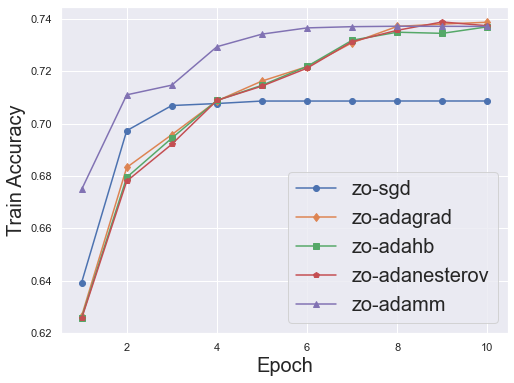

In [191]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

x = range(1,11)

plt.figure(figsize=(8,6))
# plt.rcParams.update({"font.size":40})
# plt.title("Train Accuracy")
plt.plot(x,zo_sgd_train_acc, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_train_acc, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_train_acc, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_train_acc, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_train_acc, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Train Accuracy",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('fashion_mnist_train_acc.png', dpi=300)
plt.show()

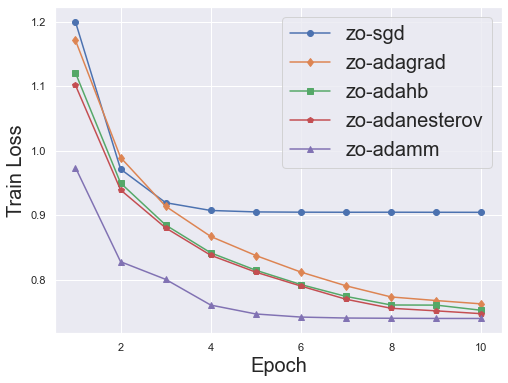

In [192]:
plt.figure(figsize=(8,6))
# plt.title("Train Loss")
plt.plot(x,zo_sgd_train_loss, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_train_loss, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_train_loss, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_train_loss, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_train_loss, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Train Loss",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('fashion_mnist_train_loss.png', dpi=300)
plt.show()

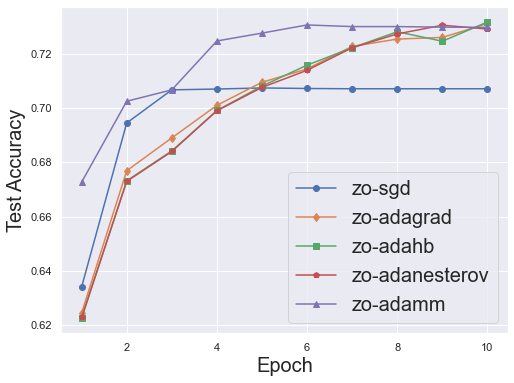

In [193]:
plt.figure(figsize=(8,6))
# plt.rcParams.update({"font.size":40})
# plt.title("Test Accuracy")
plt.plot(x,zo_sgd_test_acc, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_test_acc, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_test_acc, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_test_acc, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_test_acc, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Test Accuracy",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('fashion_mnist_test_acc.png', dpi=300)
plt.show()

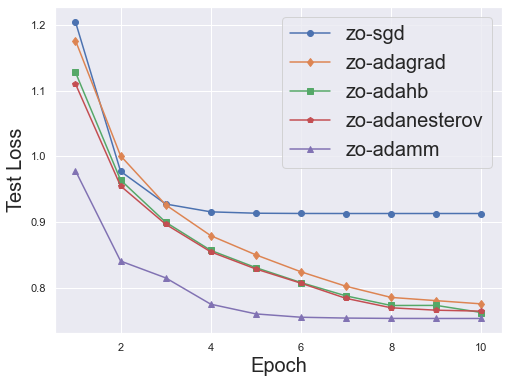

In [194]:
plt.figure(figsize=(8,6))
# plt.title("Test Loss")
plt.plot(x,zo_sgd_test_loss, marker='o', label='zo-sgd')
plt.plot(x,zo_ada_test_loss, marker='d', label='zo-adagrad')
plt.plot(x,zo_adahb_test_loss, marker='s', label='zo-adahb')
plt.plot(x,zo_adanesterov_test_loss, marker='p', label='zo-adanesterov')
plt.plot(x,zo_adamm_test_loss, marker='^', label='zo-adamm')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Test Loss",fontsize=20)
plt.grid(c='w')
plt.legend(fontsize=20)
plt.savefig('fashion_mnist_test_loss.png', dpi=300)
plt.show()